<a href="https://colab.research.google.com/github/nupursjsu/Deep-Learning/blob/master/assignment_2/AutoDiff.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Autodiff python library from scratch and MNIST classification based on that**

In [0]:
#importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt

In [0]:
class MyTensor:

    def __init__(self, data, req_grad=False):
        self.data = data
        if not isinstance(data, np.ndarray):
            self.data = np.array(data)
  
        # defining to do backprop or not
        self.req_grad = req_grad

        # defining my tensor gradient
        self.gradient = None

        # defining operation to perform if tensor used
        self.grad_fun = None

    @property
    def shape(self):
        return self.data.shape

    @property
    def grad_fun(self):
        if not self.req_grad:
            raise Exception('Backpropogation did not ran on given tensor')
        return self.grad_fun

    @property
    def gradient(self):
        return self.gradient

    def bckwd(self, gradient=None):
        if not self.grad_fun:
            return False

        if gradient is None and self.gradient is None:
            # if the tensor is last loss tensor
            gradient = self.__class__(1., req_grad=False)

        elif self.gradient is not None:
            gradient = self.gradient

        if not self.req_grad:
            raise Exception('Backpropogation did not ran on given tensor')

        self.grad_fun.bckwd(gradient)
        return True

    def __str__(self):
        return f'MyTensor({str(self.data)})'

    def add_gradient(self, gradient):
        if self.gradient is None:
            self.gradient = gradient
        else:
            self.gradient += gradient

    def __add__(self, o): 
        if self.data is not None:
            self.data += o.data  
            return self
        self.data = o.data 
        return self

In [0]:
#Defining operations
class Operation:

    def fwd(self):
        raise NotImplemented

    def bckwd(self, gradient):
        raise NotImplemented

    def __call__(self, *args):
        self.output = self.fwd(*args)
        self.output.grad_fun = self
        return self.output

In [0]:
#Defining addition operation for two tensors
class AddOperation(Operation):

    def fwd(self, a: MyTensor, b: MyTensor):
        self.a = a
        self.b = b
        
        # if any one of the input tensor is backpropogated the created tensor should be backpropagated
        req_grad = a.req_grad or b.req_grad
        return MyTensor(a.data + b.data, req_grad=req_grad)

    def bckwd(self, gradient):
        if self.a.req_grad:
            # performing summation of gradient values by missed axis because of matrix operation
            if self.a.shape != gradient.shape:
                axis = np.argmax(np.abs(np.array(self.a.shape) - 
                                 np.array(gradient.shape)))
                self.a.add_gradient(MyTensor(gradient.data.sum(axis=axis, 
                                                keepdims=True)))
            else:
                self.a.add_gradient(gradient)
            if self.a.grad_fun:
                self.a.bckwd()
        if self.b.req_grad:
            if self.b.shape != gradient.shape:
                axis = np.argmax(np.abs(np.array(self.b.shape) - 
                                        np.array(gradient.shape)))
                self.b.add_gradient(MyTensor(gradient.data.sum(axis=axis, 
                                                keepdims=True)))
            else:
                self.b.add_gradient(gradient)
            if self.b.grad_fun:
                self.b.bckwd()


In [0]:
#Defining multiplication operation for two tensors
class MultOperation(Operation):

    def fwd(self, a: MyTensor, b: MyTensor):
        self.a = a
        self.b = b
        req_grad = a.req_grad or b.req_grad
        return MyTensor(a.data * b.data, req_grad=req_grad)

    def bckwd(self, gradient):
        if self.a.req_grad:
            print(self.a, self.a.gradient, gradient)
            self.a.add_gradient(MyTensor(gradient.data * self.b.data, False))
            if self.a.grad_fun:
                self.a.bckwd()
        if self.b.req_grad:
            self.b.add_gradient(MyTensor(gradient.data * self.a.data, False))
            if self.b.grad_fun:
                self.b.bckwd()

##**Creating our own Neural Network for MNIST classification**

In [0]:
#Creating Layer class
class Layer:

    def fwd(self):
        raise NotImplemented

    def bckwd(self, gradient):
        raise NotImplemented

    def __call__(self, *args):
        return self.fwd(*args)

In [0]:
#Defining Sigmoid activation
class Sigmoid:

    def fwd(self,a):
        self.a = a   
        return 1/(1+np.exp(-a))

    def bckwd(self, gradient):
        input = self.a*(1-self.a) * gradient
        return input

In [0]:
#Defining Relu activation layer
class Relu(Layer):

    def fwd(self,a):
        self.a = a
        return np.maximum(np.zeros_like(a), a)

    def bckwd(self, gradient):
        input = (self.a > 0) * gradient
        return input

In [0]:
#Implementing softmax crossentropy
class Softmax(Layer):

    def fwd(self, a, b):
        self.a = a
        self.b = b

        expo = np.exp(a) 
        self.softmax = expo / np.sum(expo, axis=-1, keepdims=True)

        lg = self.softmax[np.arange(a.shape[0]),b]
        lg_likelihood = -np.log(lg)
        calc_loss = np.sum(lg_likelihood) / a.shape[0]
        return calc_loss

    def bckwd(self, gradient=None):
        btch = self.a.shape[0]
        gradient = self.softmax
        gradient[np.arange(btch),self.b] -= 1
        gradient = gradient/btch
        return gradient

In [0]:
#Implementing mean square error
class Mean_Square_Error(Layer):

    def fwd(self, a, b):
        self.a = a
        self.b = b
        return ((a - b)**2) / (self.a.shape[0]*2)

    def bckwd(self, gradient=None):
        return (self.a - self.b) / self.a.shape[0]

In [0]:
#Defining a Linear network layer
class Linear(Layer):

    def __init__(self, ip, op, lr=0.0001):
        self.x = 2*np.random.random((ip, op)) - 1
        self.y = 2*np.random.random((op)) - 1
        self.lr = lr

    def fwd(self, a):
        self.a = a
        return np.dot(a,self.x) + self.y

    def bckwd(self, gradient):
        grad_y = gradient.mean(axis=0)*self.a.shape[0]
        grad_x = np.dot(self.a.T, gradient)
        input = np.dot(gradient, self.x.T)

        self.x -= grad_x * self.lr
        self.y -= grad_y * self.lr

        return input

##**Doing MNIST classification using our custom neural network**

I have used PyTorch utils to make the task a bit easy.

In [60]:
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader

class MyModel(Layer):

    def __init__(self, lr=0.00001):
        self.lr = lr
        self.layers = [
            Linear(784,100, lr=self.lr),
            Relu(),
            Linear(100,200, lr=self.lr),
            Relu(),
            Linear(200,10, lr=self.lr)        
        ]

    def fwd(self,a):
        for i in self.layers:
            a = i(a)
        return a

    def bckwd(self, gradient):
        for i in self.layers[::-1]:
            gradient = i.bckwd(gradient)

        return gradient


data = transforms.Compose([
    transforms.ToTensor(), # converts to [0,1] interval
])
df = MNIST('./mnist', download=True, transform=data)
load = DataLoader(df, batch_size=2, pin_memory=True, drop_last=True) 

model = MyModel()
calc_loss = Softmax()
average_loss = 0 
for e in range(5):
    for i, (img, label) in enumerate(ld):
        x = img.view(2,-1).numpy()

        result = model(x)
        _loss = calc_loss(result, label.numpy())
        average_loss += _loss.mean() # running loss mean
        gradient = calc_loss.bckwd(1)
        model.bckwd(gradient)

        if i % 100 == 0:
            print(average_loss/100)
            average_loss = 0
            print('---------')

1.05770420923617
---------
160.38580570110014
---------
149.57572081160865
---------
141.22733978984746
---------
145.94065672858721
---------
134.23143993056948
---------
117.99302415216971
---------
138.10183121168086
---------
99.59470342347984
---------
101.46925489479607
---------
105.76887231353224
---------
102.43427907647674
---------
98.60121791449833
---------
93.37753486363584
---------
92.60180513102915
---------
88.60424584086377
---------
85.87788753766536
---------
83.41019056217259
---------
89.87035007466126
---------
96.11098826650446
---------
83.54680111072845
---------
81.34029490731402
---------
77.10388269747018
---------
72.2401091691109
---------
82.31728851150002
---------
78.64389959298681
---------
74.05532232347444
---------
72.44116148417471
---------
67.51895629984479
---------
67.04823009772905
---------
71.58804553161849
---------
64.67671266182448
---------
68.57303617618508
---------
60.720781278499835
---------
62.14442477308894
---------
62.21141770

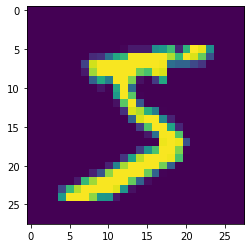

target: 5 predicted: 5


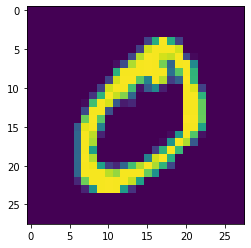

target: 0 predicted: 0


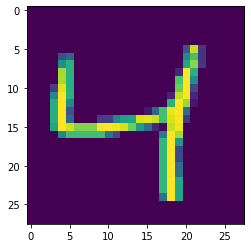

target: 4 predicted: 8


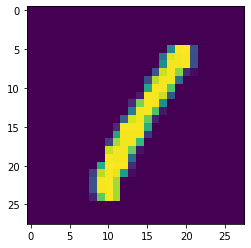

target: 1 predicted: 1


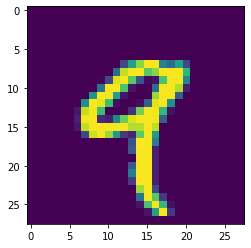

target: 9 predicted: 9


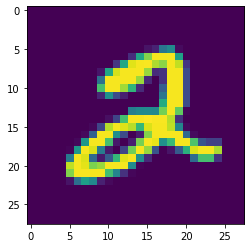

target: 2 predicted: 9


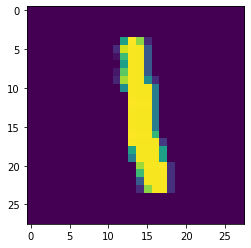

target: 1 predicted: 1


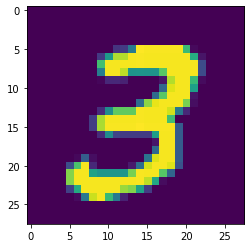

target: 3 predicted: 3


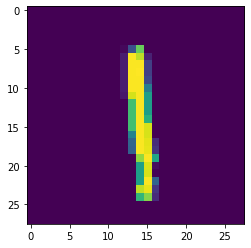

target: 1 predicted: 1


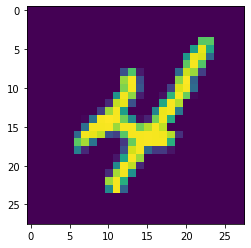

target: 4 predicted: 4


In [61]:
#Displaying top 10 predictions
for i in range(10):
    img, target = ds[i]
    plt.imshow(img[0])
    plt.show()
    x = img.view(1,-1).numpy()
    result = model(x)[0]
    prediction = np.argmax(result)
    print(f'target: {target} predicted: {prediction}' )